100%|██████████| 400/400 [01:05<00:00,  6.14it/s]


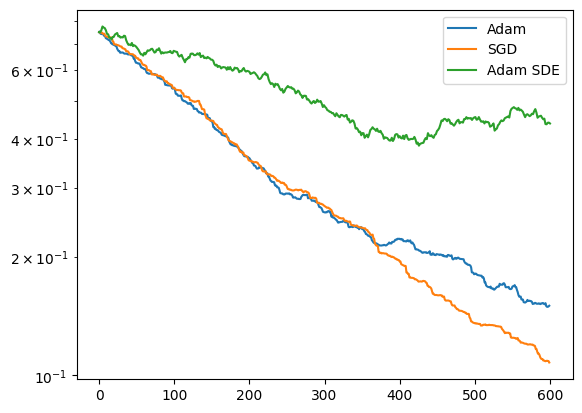

In [1]:
from optimizers import Adam, SGD
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm

import matplotlib.pyplot as plt

# Setup the problem and parameters

problem_type = 'linreg' # from  'logreg' or 'linreg' or 'lip_phaseret' or 'real_phaseret'

d = 300 # dimension
m = 1
beta1 = 0 
beta2 = 0.7
T = 2 # time to run SDE for

lr = 1.2 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

cov = jnp.linspace(0.1, 1.5, d) # initialize with diagonal covariance
# cov = jnp.diag(cov)

# params0 = jnp.linspace(2,0.1,d)
# optimal_params = jnp.linspace(0.1,2,d)
key = jax.random.PRNGKey(0)
key_init, key_opt, key = jax.random.split(key, 3)

params0 = jax.random.normal(key_init, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)


# Run the optimizers
adam = Adam(problem_type)
sgd = SGD(problem_type)

_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)

# Run the SDE equivalents
# sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

# params, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2)

# Run the ODE equivalents
# adam_ode = AdamODE(problem_type)
# sgd_ode = SgdODE(problem_type)

# sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
# adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(sgd_risks, label = 'SGD')

plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
# plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

# plt.plot(time * d, adam_risk, label = 'Adam ODE')
# plt.plot(time * d, sgd_risk, label = 'SGD ODE')

plt.legend()
plt.show()

In [2]:
from utils import make_B
n_samples = 2
beta = beta2

def f(q):
    q1 = q[:,:,0:m]
    q2 = q[:,:,m:]
    return q1 - q2

B = make_B(params0, optimal_params, cov)

key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)

history_length = 50
Q = jax.random.multivariate_normal(key_Q, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, 1))
z = jax.random.normal(key_z, (n_samples,1))

Q_history = jax.random.multivariate_normal(key_Q_hist, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, history_length))
z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
history_average = (1 - beta) * jnp.einsum('abc,b->ac', f(Q_history)**2 * z_history[:,:,None]**2, decay_vec)


fq = f(Q)
fq = fq.squeeze()        

vvv = (z**2 * fq**2 / (history_average + (1-beta) * z**2 * fq**2))
op = jnp.einsum('ab,ac->abc', vvv, vvv)


In [3]:
m = 1

cov = jnp.linspace(0.1, 1.5, d) # initialize with diagonal covariance
# cov = jnp.diag(cov)

key = jax.random.PRNGKey(0)
key_init, key_opt, key = jax.random.split(key, 3)

params0 = jax.random.normal(key_init, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)



from utils import make_B
n_samples = 2000
beta = beta2

def f(q):
    q1 = q[:,:,0:m]
    q2 = q[:,:,m:]
    return q1 - q2

B = make_B(params0, optimal_params, cov)

key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)
Binv = jnp.linalg.inv(B)

history_length = 500
Q = jax.random.multivariate_normal(key_Q, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples,1))
z = jax.random.normal(key_z, (n_samples,1))

Q_history = jax.random.multivariate_normal(key_Q_hist, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, history_length))
z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
# history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
history_average = (1 - beta) * jnp.einsum('abc,b->ac', f(Q_history)**2 * z_history[:,:,None]**2, decay_vec)


print(f(Q).shape)
fq = f(Q).squeeze(axis=1)
Q = Q.squeeze()
print(history_average.shape)
print(Q.shape)
print(fq.shape)

phi_coef = z**2 * fq / jnp.sqrt( history_average + (1-beta) * z**2 * fq**2)
print(phi_coef.shape)

phi_coef = jnp.concatenate([phi_coef,phi_coef], axis = 1)

print(phi_coef.shape)
print(Q.shape)
print(f'BINV: {Binv.shape}')

phi = jnp.mean(phi_coef * Q @ Binv, axis = 0)
print(phi.shape) # We expect shape 2m

(2000, 1, 1)
(2000, 1)
(2000, 2)
(2000, 1)
(2000, 1)
(2000, 2)
(2000, 2)
BINV: (2, 2)
(2,)


In [4]:
Binv.shape

(2, 2)

In [5]:
(Q @ Binv).shape

(2000, 2)

In [6]:
1.2366915e-04**2

1.52940586617225e-08

In [7]:
jnp.outer(vvv[0,:],vvv[0,:])

Array([[1.8765713e-04, 2.8261007e-05],
       [2.8261007e-05, 4.2560837e-06]], dtype=float32)

In [8]:
B.shape

(2, 2)

In [9]:
z.shape

(2000, 1)

In [10]:
z**2 * fq**2 / (history_average + (1-beta) * z**2 * fq**2)

Array([[0.13206473],
       [0.83580405],
       [2.7171264 ],
       ...,
       [0.7984618 ],
       [0.00418052],
       [0.01582386]], dtype=float32)